## Imports

In [1]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive
from numpyro.infer.initialization import init_to_value

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

from jax import config

config.update("jax_enable_x64", True)

display(jax.devices())

import pickle

import os
import sys

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.NumPyroModels import NumPyroModel
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *
from src.utils.numpyro_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

## Creating Data Set

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    pass
    #plot_data_generation_diff(etas_train)

/home/cgrogan/UncertaintyQuantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


## Scaling Data and Converting

In [3]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float64)
y_train = jnp.array(y_scaled_train, dtype=jnp.float64)

2024-10-02 15:17:06.498174: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Network and HMC parameters

In [4]:
hmc_checkpoints = "../Model_Checkpoints/HMC/"

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 5e-5
trajectory_length = 0.01
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

init_dict = pickle.load(open(hmc_checkpoints+"HMC_Initialize_large.pkl", "rb"))

for key, value in init_dict.items():
    print(key)
    init_dict[key] = jnp.array(value.astype(jnp.float64).T)
    print(init_dict[key].shape)

net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "hidden_dim": 20,
    "num_layers": 4,
    "data_size": len(x_train),
    "layer_prior_scale": 5.0,
}

hmc_params = {
    "model": NumPyroModel(**net_params),
    "step_size": step_size,
    "trajectory_length": trajectory_length,
    "adapt_step_size": False,
    "dense_mass": True,
    "init_strategy": init_to_value(values=init_dict),
}

mcmc_params = {
    "num_warmup": 10,
    "num_samples": 10,
    "num_chains": 1
}



Number of Steps:  199
w1
(2, 20)
b1
(20,)
w2
(20, 20)
b2
(20,)
w3
(20, 20)
b3
(20,)
w4
(20, 3)
b4
(3,)


In [5]:
warm_state = pickle.load(open("../Model_Checkpoints/HMC/HMC_1000_1000_100_warm_state.pkl", "rb"))
last_state = pickle.load(open("../Model_Checkpoints/HMC/HMC_1000_1000_100_last_state.pkl", "rb"))

cov_1 = warm_state.adapt_state.inverse_mass_matrix
mass_dict = last_state.adapt_state.inverse_mass_matrix
cov_2 = list(mass_dict.values())[0]

test = 1

FileNotFoundError: [Errno 2] No such file or directory: '../Model_Checkpoints/HMC/HMC_1000_1000_100_warm_state.pkl'

## Run Training

In [9]:
print(hmc_params["model"])

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train)

Layer 1: 2 -> 20
Layer 2: 20 -> 20
Layer 3: 20 -> 20
Layer 4: 20 -> 3



sample: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it, 200 steps of size 5.00e-05. acc. prob=1.00]


## Saving MCMC Run

In [10]:
save_prefix = f"HMC_{mcmc_params['num_warmup']}_{mcmc_params['num_samples']}_{num_steps}"

save_numpyro_mcmc(mcmc, hmc_checkpoints, save_prefix)

[3052 4843 2493 5332  181 4606 3945 6614 1041 4655 3270 1431 3847 5540
 1286  660 1777 5660 5550 5734 6818 2304 4774 6679   61 2209 5434 2470
  966 4195 3444 1565 2799 2829 3209 4701 3716 3830 2653 5803  473 6464
 2626 4726 5549 5198 5833 5032 4165 5975 6453 4728 2430 3973 2222 6104
 6453  455 5877 6383 5688  191 3313 4372 4167 3040 2744 6967 3107 1094
 5071 6991  137 1211 2268 6381 6723  567 1078 5341 5270 6650  970 6515
 6713 3302 2804 2048 5299 5142  153 2908 4803 3583  518 6798 5597 1162
 6817 2630 5469 4042  998 2632 4398 5656 1961 4725 2612 1039 4745 5122
 2551 4667 3095 6581  188 5159 1441 2882 4990 2670  716  301  868 6660
 3085 2041 6981  971 3241 3032 4142 3266  178   23 1394 5849 3771 2445
 4570 1317 2994 4146 5553 3256 2554 3314  704 5984  767 3381  355 3575
 5949  902 6863  981 3529 6307   26 3423 6963 5445 4219 4343 3856 1990
 2675 3263 6372 4391 6219 3282  949 1931 6890 2748 3796 5019 6247   58
 4524 5402 2222 4282 3100 4418 1457 5334 3300 1802 2517 3101 3910 2277
 4453 

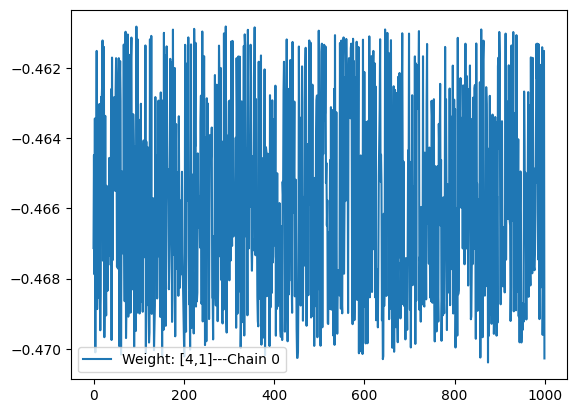

In [6]:
saves = "../Model_Checkpoints/NUTS/HMC_6000_6000_150000"
num_samples = 2
samples = []

samples_dict = pickle.load(open(saves+'_samples.pkl', 'rb'))
last_state = pickle.load(open(saves+'_last_state.pkl', 'rb'))


for k, v in samples_dict.items():
    samples_dict[k] = jnp.expand_dims(v, 0)

num_samples = 1000
sample_ind = np.random.randint(samples_dict['w1'].shape[1], size=num_samples)

print(sample_ind)

# exclude samples
for key, value in samples_dict.items():
    print(key, value.shape)
    samples_dict[key] = value[:, sample_ind,...]

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

mcmc._states = {'z': samples_dict}
mcmc._last_state = last_state

print(mcmc.print_summary())


for key, value in samples_dict.items():
    print(key, value.shape)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex']= False

params = samples_dict['w1']

ind1 = 4
ind2 = 1
for i in range(1):
    plt.plot(params[0, :, ind1, ind2], label=f"Weight: [{ind1},{ind2}]---Chain {i}")

plt.legend()
plt.show()

## Predictions

/home/cgrogan/UncertaintyQuantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


5.585710472513881


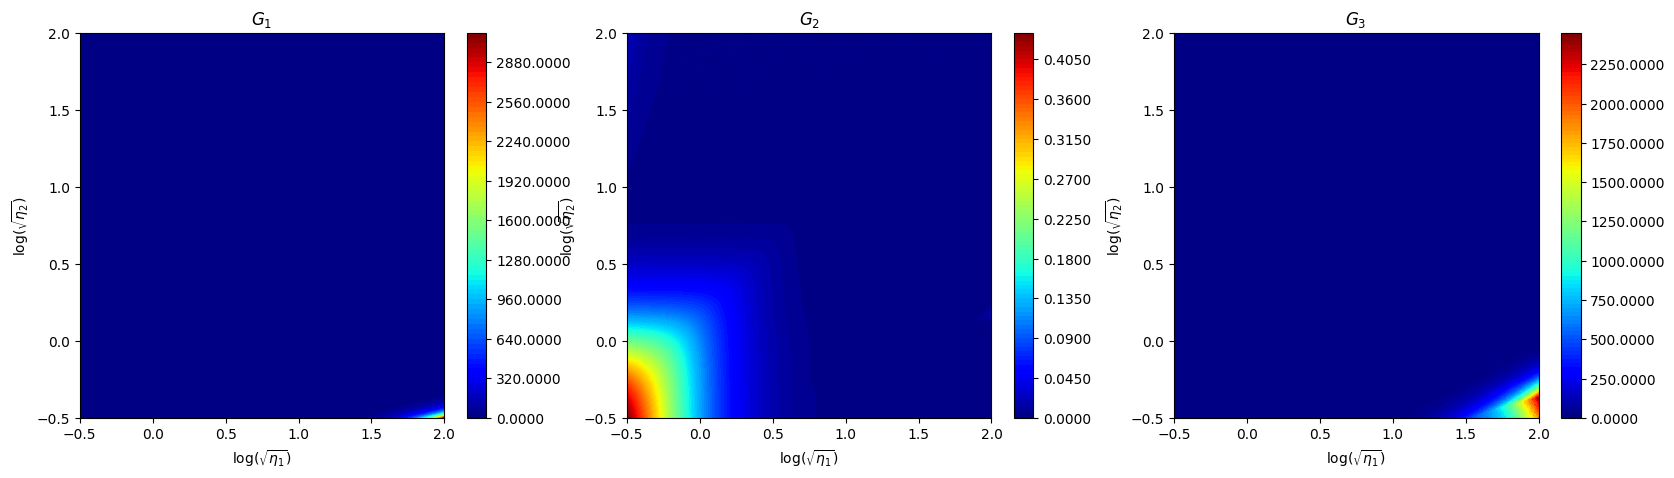

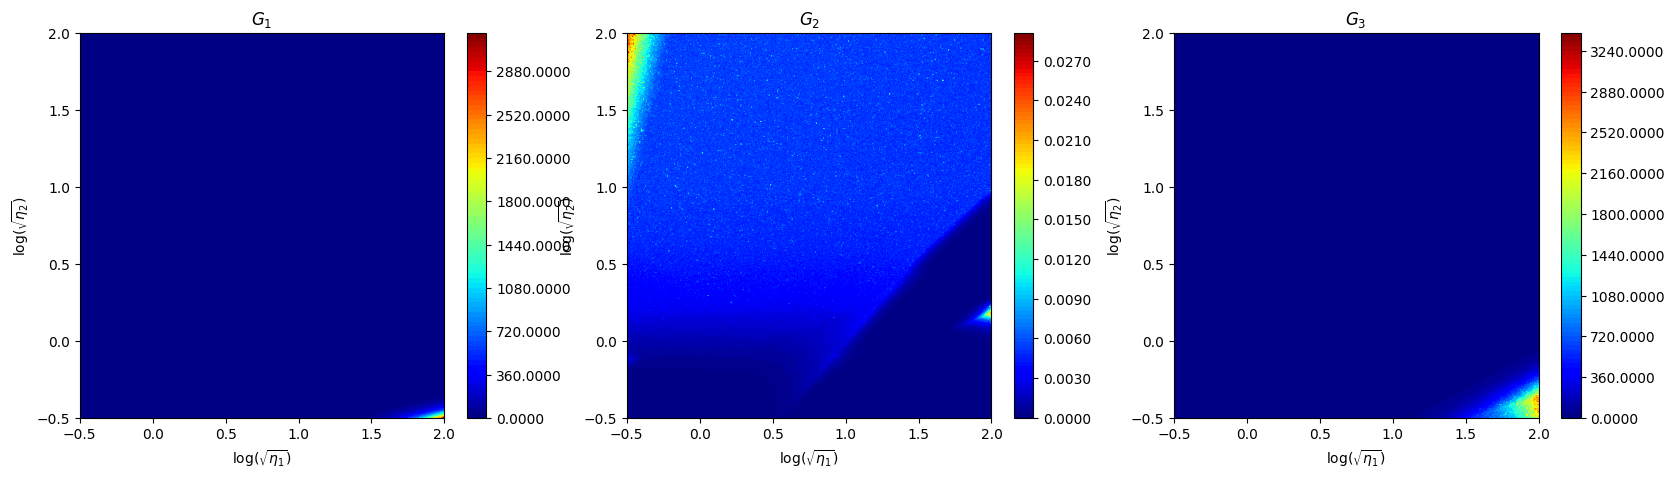

In [7]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG")
etas, G_s = gen(eta1, eta2)

etas = jnp.array(etas)
target = jnp.array(G_s)

model_test = NumPyroModel(**net_params)
model_test.data_size = etas.shape[0]

etas = x_scaler.transform(etas)

predictive = Predictive(model_test, posterior_samples=mcmc.get_samples())

pred = np.array(predictive(random.PRNGKey(0), etas)['Y'])

for i in range(pred.shape[0]):
    pred[i] = y_scaler.inverse_transform(pred[i])

pred_mean = jnp.mean(pred, axis=0)
pred_std = jnp.std(pred, axis=0)

del pred
del predictive

print(jnp.mean(jnp.abs(target - pred_mean)))

target = target.T.reshape(3, dim, dim)
pred_mean = pred_mean.T.reshape(3, dim, dim)
pred_std = pred_std.T.reshape(3, dim, dim)

plot_heat_map_3D(x_grid, y_grid, np.abs(pred_mean - target))

plot_heat_map_3D(x_grid, y_grid, pred_std)